In [8]:
import torch
import os
import time
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import sys

# Add parent directory to path so we can import our utility modules
sys.path.append("../")

from diffusers import (
    StableDiffusionControlNetPipeline,
    StableDiffusionPipeline,
    ControlNetModel,
    EulerAncestralDiscreteScheduler,
)

# Import our modified call function - you might need to create this file
# This is where the custom controlnet function is defined
from utils.controlnet import call_control_net

# Replace the standard call function with our custom one
StableDiffusionControlNetPipeline.__call__ = call_control_net

# Define callback tensor inputs for our custom function
StableDiffusionControlNetPipeline._callback_tensor_inputs = [
    "dt_latents",
    "latents",
    "prompt_embeds",
    "negative_prompt_embeds",
]

In [41]:
# Global settings
DEFAULT_SD_MODEL_ID = "stable-diffusion-v1-5/stable-diffusion-v1-5"  # Base SD model
IMAGE_FOLDER = "../images/conditions/"  # Folder containing conditioning images
SAVE_PATH = "../outputs/hybrid/"  # Where to save the output images
CSV_PATH = "controlnet_inputs.csv"  # Path to CSV file with parameters

# Default parameters (can be overridden by CSV)
DEFAULT_CONTROL_TYPE = "canny"  # Default control type
DEFAULT_SWITCH_STEP = 30  # Default step to switch from ControlNet to standard SD
DEFAULT_GUIDANCE_SCALE = 7.5  # Default guidance scale
DEFAULT_CONDITIONING_SCALE = 1.0  # Default ControlNet conditioning scale
DEFAULT_NUM_INFERENCE_STEPS = 50  # Default number of inference steps

# Device and weight type
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
WEIGHT_DTYPE = torch.float16 if torch.cuda.is_available() else torch.float32

# Create output directory if it doesn't exist
os.makedirs(SAVE_PATH, exist_ok=True)

In [42]:
# Load the CSV file
df = pd.read_csv(CSV_PATH)

# Display the first few rows
print(f"Loaded {len(df)} rows from {CSV_PATH}")
df.head()

Loaded 15 rows from controlnet_inputs.csv


,file_path,prompt,control_type,run_controlnet_till_step,guidance_scale,conditioning_scale,num_inference_steps
0,canny,A photorealistic recreation of 'Girl with a Pe...,canny,10,7.5,1.0,50
1,canny,A photorealistic recreation of 'Girl with a Pe...,canny,20,7.5,1.0,50
2,canny,A photorealistic recreation of 'Girl with a Pe...,canny,30,7.5,1.0,50
3,canny,A photorealistic recreation of 'Girl with a Pe...,canny,40,7.5,1.0,50
4,canny,A photorealistic recreation of 'Girl with a Pe...,canny,50,7.5,1.0,50


In [43]:
# Dictionary mapping control types to model IDs
CONTROLNET_MODEL_IDS = {
    "canny": "lllyasviel/sd-controlnet-canny",
    "depth": "lllyasviel/sd-controlnet-depth",
    "hed": "lllyasviel/sd-controlnet-hed",
    "mlsd": "lllyasviel/sd-controlnet-mlsd",
    "normal": "lllyasviel/sd-controlnet-normal",
    "pose": "lllyasviel/sd-controlnet-openpose",
    "scribble": "lllyasviel/sd-controlnet-scribble",
    "seg": "lllyasviel/sd-controlnet-seg",
}


# Function to get model ID from control type
def get_controlnet_model_id(control_type):
    return CONTROLNET_MODEL_IDS.get(
        control_type.lower(), f"lllyasviel/sd-controlnet-{control_type.lower()}"
    )

In [44]:
# Load the standard Stable Diffusion pipeline
standard_pipe = StableDiffusionPipeline.from_pretrained(
    DEFAULT_SD_MODEL_ID,
    torch_dtype=WEIGHT_DTYPE,
    safety_checker=None,
)
standard_pipe.to(DEVICE)
standard_pipe.set_progress_bar_config(disable=True)
print("Standard SD pipeline loaded successfully.")

# Cache for ControlNet pipelines
controlnet_pipelines = {}

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Standard SD pipeline loaded successfully.


In [45]:
def get_controlnet_pipeline(control_type):
    """
    Get or create a ControlNet pipeline for the specified control type.
    Cache the pipelines for reuse.
    """
    if control_type in controlnet_pipelines:
        return controlnet_pipelines[control_type]

    # Get the model ID for the control type
    controlnet_model_id = get_controlnet_model_id(control_type)

    # Load the ControlNet model
    controlnet = ControlNetModel.from_pretrained(
        controlnet_model_id, torch_dtype=WEIGHT_DTYPE
    )

    # Load the ControlNet pipeline
    pipe = StableDiffusionControlNetPipeline.from_pretrained(
        DEFAULT_SD_MODEL_ID,
        controlnet=controlnet,
        torch_dtype=WEIGHT_DTYPE,
        safety_checker=None,
    )

    # Set scheduler and move to device
    pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
    pipe.enable_model_cpu_offload()
    pipe.set_progress_bar_config(disable=True)

    # Cache the pipeline
    controlnet_pipelines[control_type] = pipe

    return pipe

In [46]:
generator = torch.Generator(
    device="cuda" if torch.cuda.is_available() else "cpu"
).manual_seed(42)

In [ ]:
import csv
import datetime


def process_csv_and_generate_images(df, image_folder, save_path):
    """



    Process each row in the CSV and generate images using the specified parameters.
    """

    # Create output directory

    os.makedirs(save_path, exist_ok=True)

    # Create runtime CSV file path
    runtime_csv_path = os.path.join(save_path, "runtime_metrics.csv")

    # Check if runtime CSV exists, if not create it with headers
    csv_exists = os.path.exists(runtime_csv_path)

    if not csv_exists:
        with open(runtime_csv_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(
                [
                    "file_path",
                    "runtime_seconds",
                    "control_type",
                    "switch_step",
                    "num_inference_steps",
                    "guidance_scale",
                    "conditioning_scale",
                ]
            )

    # Track results and timing

    results = []

    total_time = 0

    # Process each row

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing images"):

        # Get parameters from row (or use defaults)

        file_path = str(row["file_path"])

        # prompt = str(row.get("prompt", ""))
        prompt = ""

        control_type = str(row.get("control_type", DEFAULT_CONTROL_TYPE))

        run_controlnet_till_step = int(
            row.get("run_controlnet_till_step", DEFAULT_SWITCH_STEP)
        )

        guidance_scale = float(row.get("guidance_scale", DEFAULT_GUIDANCE_SCALE))

        conditioning_scale = float(
            row.get("conditioning_scale", DEFAULT_CONDITIONING_SCALE)
        )

        num_inference_steps = int(
            row.get("num_inference_steps", DEFAULT_NUM_INFERENCE_STEPS)
        )

        # Output file path

        output_path = f"{save_path}/{control_type}_{run_controlnet_till_step}.png"

        # Skip if the output already exists

        if os.path.exists(output_path):

            print(f"Skipping {file_path} (already exists)")
            continue

        # Input image path

        image_path = f"{image_folder}/{file_path}.png"

        if not os.path.exists(image_path):

            print(f"Warning: Image not found at {image_path}, skipping")
            continue

        try:

            # Load the conditioning image

            conditioning_image = Image.open(image_path).convert("RGB")

            # Get the appropriate ControlNet pipeline

            controlnet_pipe = get_controlnet_pipeline(control_type)

            # Generate the image

            start_time = time.perf_counter()

            output = controlnet_pipe(
                prompt=prompt,
                image=conditioning_image,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps,
                controlnet_conditioning_scale=conditioning_scale,
                standard_sd_pipeline=standard_pipe,
                run_controlnet_till_step=run_controlnet_till_step,
                generator=generator,
            )

            end_time = time.perf_counter()

            runtime = end_time - start_time

            total_time += runtime

            # Get the output images

            standard_image = output.images[0][0]

            # Save the standard image

            standard_image.save(output_path)

            with open(runtime_csv_path, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(
                    [
                        file_path,
                        f"{runtime:.4f}",
                        control_type,
                        run_controlnet_till_step,
                    ]
                )

            print(f"Generated {file_path} in {runtime:.2f}s")

        except Exception as e:

            print(f"Error processing {file_path}: {str(e)}")

            results.append({"file_path": file_path, "error": str(e), "success": False})

    # Print summary

    success_count = sum(1 for r in results if r.get("success", False))

    print(
        f"\nProcessed {len(results)} images. {success_count} successful, {len(results) - success_count} failed."
    )

    if success_count > 0:

        print(f"Average runtime: {total_time / success_count:.2f}s per image")

    return results

In [48]:
# Run the image generation process
results = process_csv_and_generate_images(df, IMAGE_FOLDER, SAVE_PATH)

Processing images:   0%|          | 0/15 [00:00<?, ?it/s]

Skipping canny (already exists)
Skipping canny (already exists)
Skipping canny (already exists)
Skipping canny (already exists)
Skipping canny (already exists)
Skipping pose (already exists)
Skipping pose (already exists)
Skipping pose (already exists)
Skipping pose (already exists)
Skipping pose (already exists)
Skipping seg_2 (already exists)
Skipping seg_2 (already exists)
Skipping seg_2 (already exists)
Skipping seg_2 (already exists)
Skipping seg_2 (already exists)

Processed 0 images. 0 successful, 0 failed.


In [ ]:
# Run the image generation process
results = process_csv_and_generate_images(
    df, IMAGE_FOLDER, "../outputs/hybrid_no_prompt/"
)

Processing images:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Switching to standard SD pipeline at step 10
Generated canny in 236.66s
Switching to standard SD pipeline at step 20
Generated canny in 230.65s
Switching to standard SD pipeline at step 30
Generated canny in 192.14s
Switching to standard SD pipeline at step 40
Generated canny in 246.03s
Generated canny in 153.25s


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Switching to standard SD pipeline at step 10
Generated pose in 242.99s
Switching to standard SD pipeline at step 20
Generated pose in 238.35s
Switching to standard SD pipeline at step 30
Generated pose in 292.25s
Switching to standard SD pipeline at step 40
Generated pose in 153.93s
Generated pose in 272.49s


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Switching to standard SD pipeline at step 10
Generated seg_2 in 194.22s
Switching to standard SD pipeline at step 20
Generated seg_2 in 188.64s
Switching to standard SD pipeline at step 30
Generated seg_2 in 154.14s
Switching to standard SD pipeline at step 40
Generated seg_2 in 200.50s
Generated seg_2 in 169.73s

Processed 0 images. 0 successful, 0 failed.


In [ ]:
def create_prompt_comparison_grid(
    no_prompt_path,
    with_prompt_path,
    control_types,
    switch_steps,
    output_path="comparison_grid.png",
):
    """
    Create a visualization grid comparing images with and without prompts.
    Each row shows a different control type.
    The grid is organized with all prompted images on the left (20%,40%,60%,80%,100%)
    and all no-prompt images on the right (20%,40%,60%,80%,100%).

    Args:
        no_prompt_path (str): Path to the folder containing images generated without prompts
        with_prompt_path (str): Path to the folder containing images generated with prompts
        control_types (list): List of control types to include in the comparison
        switch_steps (list): List of switch steps to include (will be converted to percentages)
        output_path (str): Path to save the output visualization
    """
    # Convert switch steps to percentages
    percentages = [int(step / 50 * 100) for step in switch_steps]

    nrows = len(control_types)
    ncols = (
        len(switch_steps) * 2
    )  # Left side for with prompts, right side for no prompts

    # Create figure with appropriate size
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 2.5, nrows * 3))

    # Ensure axs is 2D even with single row
    if nrows == 1:
        axs = np.expand_dims(axs, axis=0)

    # Add title
    plt.suptitle(
        "Comparison of Images Generated using Hybrid-Control-Net With and Without Prompts",
        fontsize=16,
    )

    # Add section headers
    mid_point = len(switch_steps)
    plt.figtext(0.25, 0.95, "WITH PROMPTS", fontsize=14, ha="center", fontweight="bold")
    plt.figtext(0.75, 0.95, "NO PROMPTS", fontsize=14, ha="center", fontweight="bold")

    # Add column headers
    for i, percentage in enumerate(percentages):
        # With prompt column header (left side)
        axs[0, i].set_title(f"{percentage}%", fontsize=12)

        # No prompt column header (right side)
        axs[0, i + mid_point].set_title(f"{percentage}%", fontsize=12)

    # Add row labels and populate with images
    for row_idx, control_type in enumerate(
        tqdm(control_types, desc="Processing control types")
    ):
        # Add row label
        row_label_ax = axs[row_idx, 0]
        # Calculate y position for the row label
        y_pos = (row_label_ax.get_position().y0 + row_label_ax.get_position().y1) / 2

        # Add row label to the left of the figure
        fig.text(
            0.01,
            y_pos,
            control_type.upper(),
            fontsize=14,
            fontweight="bold",
            ha="left",
            va="center",
            rotation=90,
        )

        # Add images for each switch step
        for col_idx, step in enumerate(switch_steps):
            # Load and display with prompt image (left side)
            with_prompt_img_path = os.path.join(
                with_prompt_path, f"{control_type}_{step}.png"
            )
            if os.path.exists(with_prompt_img_path):
                with_prompt_img = Image.open(with_prompt_img_path)
                axs[row_idx, col_idx].imshow(np.array(with_prompt_img))
                axs[row_idx, col_idx].axis("off")
            else:
                axs[row_idx, col_idx].text(
                    0.5, 0.5, "Image not found", ha="center", va="center"
                )
                axs[row_idx, col_idx].axis("off")

            # Load and display no prompt image (right side)
            no_prompt_img_path = os.path.join(
                no_prompt_path, f"{control_type}_{step}.png"
            )
            if os.path.exists(no_prompt_img_path):
                no_prompt_img = Image.open(no_prompt_img_path)
                axs[row_idx, col_idx + mid_point].imshow(np.array(no_prompt_img))
                axs[row_idx, col_idx + mid_point].axis("off")
            else:
                axs[row_idx, col_idx + mid_point].text(
                    0.5, 0.5, "Image not found", ha="center", va="center"
                )
                axs[row_idx, col_idx + mid_point].axis("off")

    # Add a vertical separator line
    separator_x = (
        axs[0, mid_point - 1].get_position().x1 + axs[0, mid_point].get_position().x0
    ) / 2
    plt.axvline(x=separator_x, color="black", linestyle="-", linewidth=1)

    # Adjust layout
    plt.tight_layout(
        rect=[0.05, 0, 1, 0.94]
    )  # Leave space for the title and row labels
    plt.subplots_adjust(wspace=0.05, hspace=0.2)

    # Save figure
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    print(f"Comparison grid saved to {output_path}")

    return fig

Processing control types:   0%|          | 0/3 [00:00<?, ?it/s]

Comparison grid saved to ../outputs/prompt_comparison.png


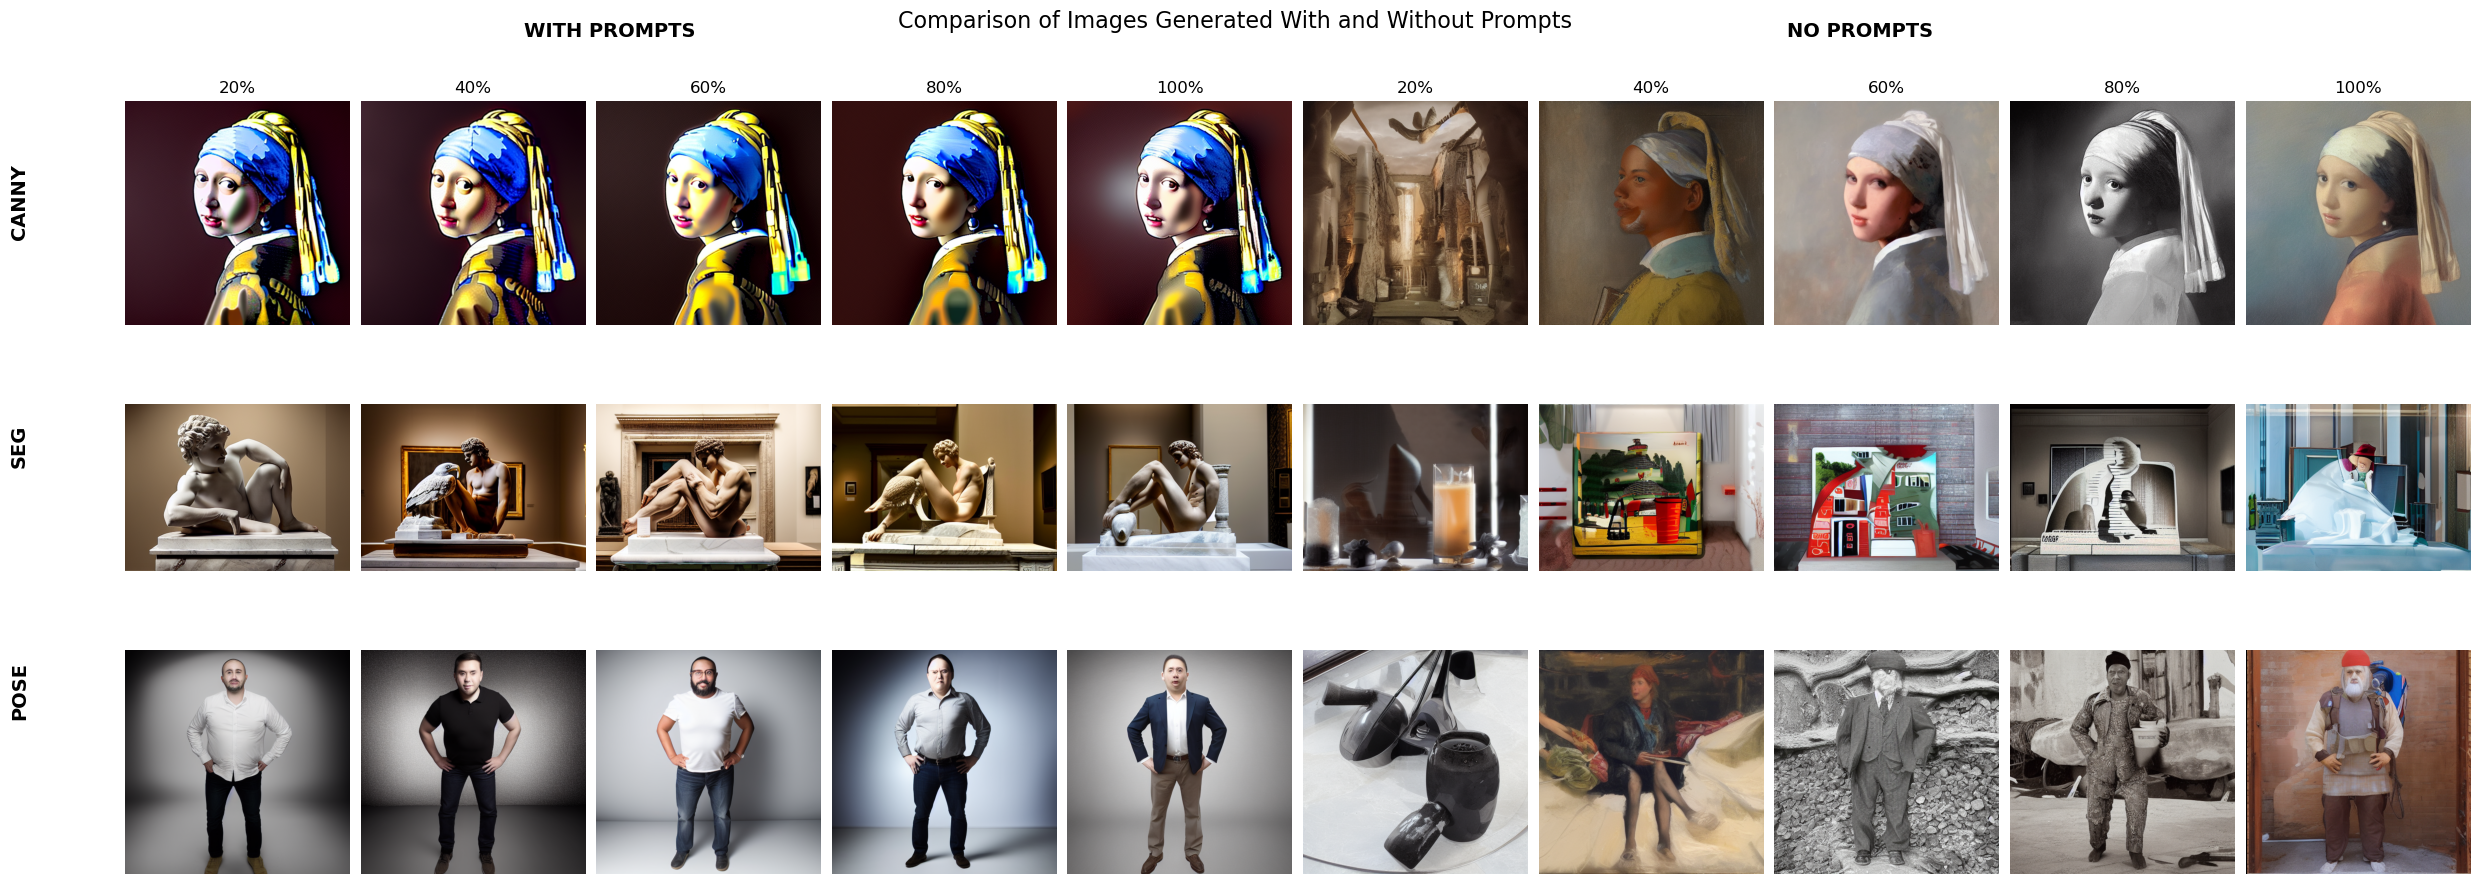

In [14]:
no_prompt_path = "../outputs/hybrid_no_prompt/"
with_prompt_path = "../outputs/hybrid/"
control_types = ["canny", "seg", "pose"]
switch_steps = [
    10,
    20,
    30,
    40,
    50,
]  # These will be converted to percentages (20%, 40%, 60%, 80%, 100%)
output_path = "../outputs/prompt_comparison.png"


fig = create_prompt_comparison_grid(
    no_prompt_path, with_prompt_path, control_types, switch_steps, output_path
)